# LSTM

In [1]:
import os
import datetime
import seaborn as sns
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
sns.set(style="darkgrid")
sns.set_palette("coolwarm_r")
path = "../../data_postprocess/data_nuevo/"

mpl.rcParams['figure.figsize'] = (8, 6)
tf.config.experimental.set_visible_devices([], 'GPU')

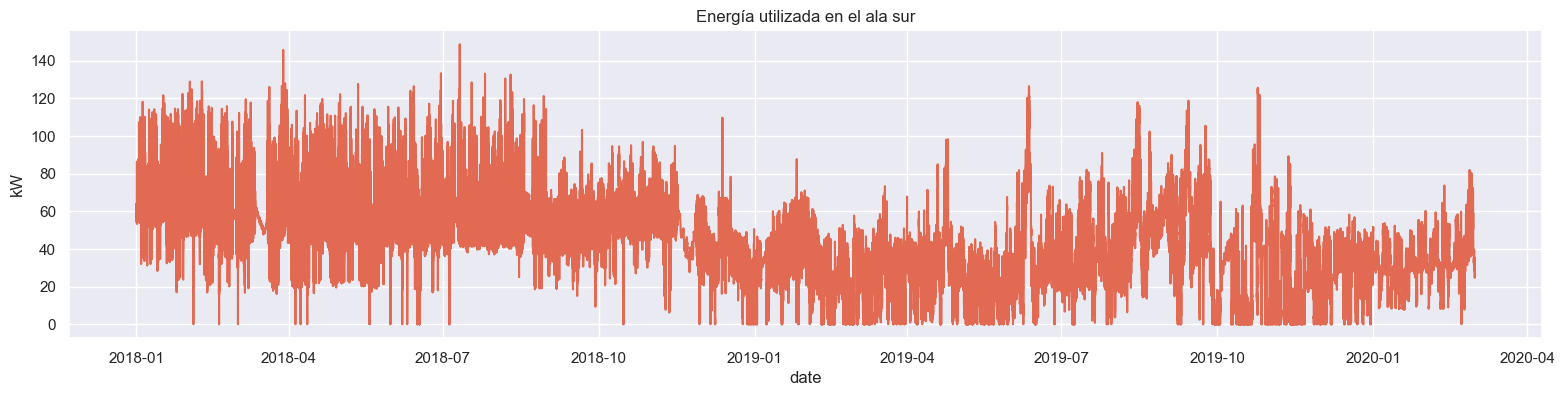

In [3]:
# Importamos csv
energy_use = pd.read_csv(path+'ele_def.csv')
#We change the date column into datetime format
energy_use['date']= pd.to_datetime(energy_use['date'])
energy_use.set_index('date', inplace=True)
energy_use= energy_use.clip(lower=0.01)
# We crop until March 2020, since it's the expected normal use (covid effect)

energy_use=energy_use[energy_use.index < '2020-03-01 00:00:00']

energy_use = energy_use.resample('15T').mean()
energy_use['hvac']= energy_use['hvac_N']+energy_use['hvac_S']
var = 'hvac'

plt.figure(figsize=(19,4))
sns.set_palette("coolwarm_r")
sns.lineplot(x =energy_use.index , y=energy_use[var])
plt.ylabel('kW')

plt.title('Energía utilizada en el ala sur')
# We crop until March 2020, since it's the expected normal use (covid effect)

energy_use=energy_use[energy_use.index < '2020-03-01 00:00:00']

energy_use = energy_use.resample('15T').mean()


In [4]:
df=energy_use.reset_index()

In [5]:
date_time = pd.to_datetime(df.pop('date'), format='%d.%m.%Y %H:%M:%S')


Text(0.5, 1.0, 'Time of day signal')

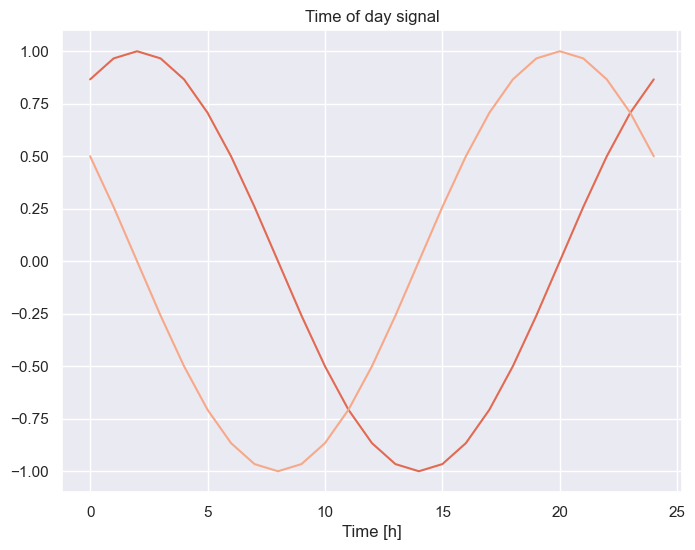

In [6]:
day = 24*60*60/4
week = (7)*day
timestamp_s = date_time.map(pd.Timestamp.timestamp)

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Week sin'] = np.sin(timestamp_s * (2 * np.pi / week))
df['Week cos'] = np.cos(timestamp_s * (2 * np.pi / week))
sns.set_palette("coolwarm_r")
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

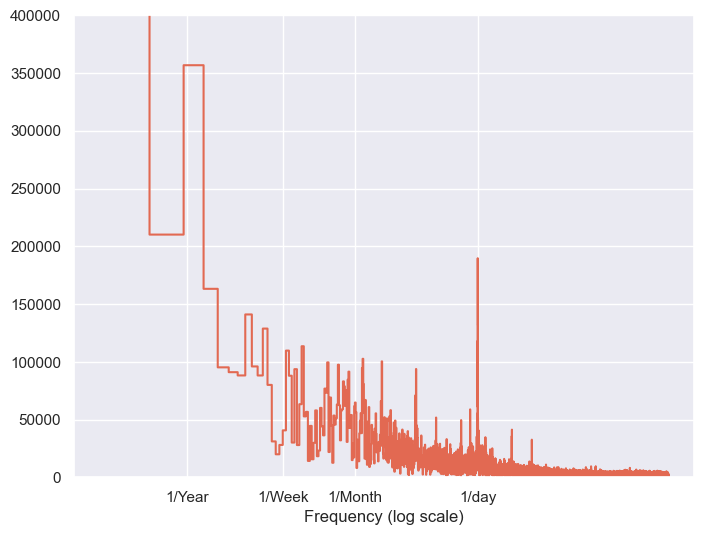

In [7]:
fft = tf.signal.rfft(df[var])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df[var])
hours_per_year = 24*365.2524*4
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
sns.set_palette("coolwarm_r")
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 7, 30, 365.2524], labels=['1/Year','1/Week','1/Month', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [8]:

n = len(df)
train_df = df[0:int(n*0.7)][['hvac', 'Day sin', 'Day cos', 'Week sin', 'Week cos']]
val_df = df[int(n*0.7):int(n*0.9)][['hvac', 'Day sin', 'Day cos', 'Week sin', 'Week cos']]
test_df = df[int(n*0.9):][['hvac', 'Day sin', 'Day cos', 'Week sin', 'Week cos']]
column_indices = {name: i for i, name in enumerate(train_df.columns)}

num_features = train_df.shape[1]

In [68]:
print(test_df.shape)

(7584, 5)


In [9]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

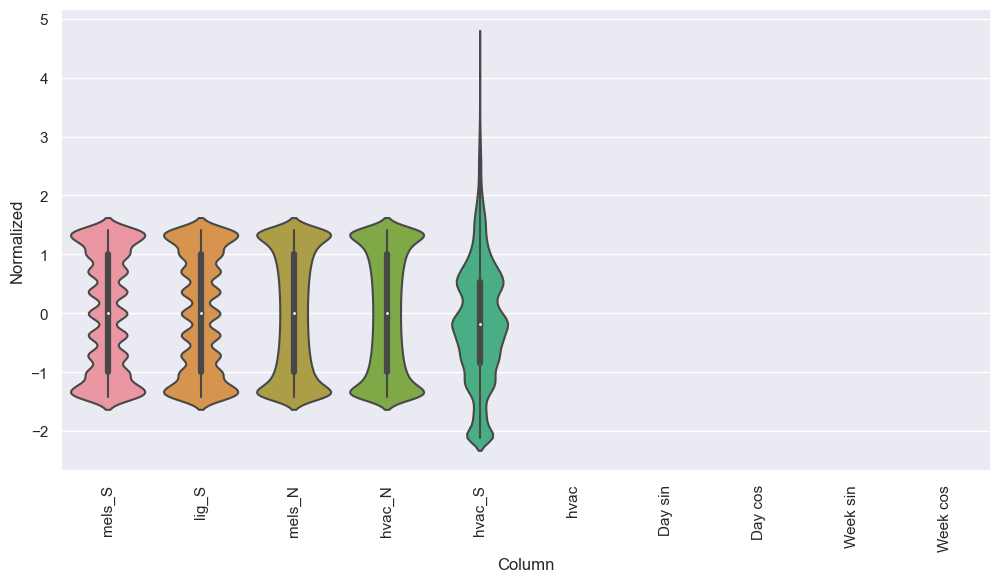

In [10]:
df_std = (df - train_mean) / train_std
sns.set_palette("coolwarm_r")
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [11]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [12]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]

  #If we have more than one label column, it stacks 
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [23]:
#Queremos predecir el valor de 4 horas seguidas (16 label) a una semana vista, con una semana de historial (7*96)
w1 = WindowGenerator(input_width=96, label_width=4, shift=96,
                     label_columns=[var])

In [81]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=self.label_width,
      shuffle=False,
      batch_size=20)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [82]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.test))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [83]:
import plotly.graph_objects as go

In [86]:
t=0
e = np.array([])
for i,_ in single_step_window.test:
    if t==0:
        predictions = baseline.predict(i, verbose=0)
        print(predictions[0])
        print(predictions[1])
        print(predictions[2])
        e=np.concatenate([e, predictions.reshape(predictions.shape[0]*predictions.shape[1])], axis=0)
        print(e)
    t =t+1
print(t)

[[-0.17437197]]
[[-0.13230759]]
[[-0.08891932]]
[-0.17437197 -0.13230759 -0.08891932 -0.21076615 -0.07584617 -0.07862803
 -0.00288164 -0.03070676 -0.15375265 -0.19977546 -0.05097513 -0.13722315
 -0.13347159 -0.11575449 -0.14306821 -0.01096032 -0.05544766 -0.16705316
 -0.1601197  -0.06800394]
380


In [90]:
def plot_test_predictions(self, model=None, plot_col=var, n_subplots=4):

  temp = self.test_df.iloc[self.total_window_size-self.label_width:]

  if model is not None:
    all_predictions = np.array([])
    for inputs, _ in self.test:
      predictions = model.predict(inputs, verbose=0)
      all_predictions = np.concatenate([all_predictions, predictions.reshape(predictions.shape[0]*predictions.shape[1])], axis=0)
    print("All predictions shape: ", all_predictions.shape)
    print("DF test shape: ", self.test_df.iloc[self.total_window_size-self.label_width:].shape)
    

  fig = go.Figure()

  # add subplot for temp['hvac_N']
  fig.add_trace(
      go.Scatter(x=temp.index, y=temp[var], mode='lines', name=var)
  )

  # add subplot for all_predictions
  fig.add_trace(
      go.Scatter(x=temp.index, y=all_predictions, mode='lines', name='predictions')
  )

  # set up layout with a sliding pane
  fig.update_layout(
      xaxis=dict(rangeslider=dict(visible=True)),
      yaxis=dict(title='Value'),
      title='HVAC and predictions',
  )

  # show the figure
  fig.show()

WindowGenerator.plot_test_predictions = plot_test_predictions

In [91]:
def plot1(self, model=None, plot_col='hvac', max_subplots=3):
  inputs, labels = self.example

  plt.figure(figsize=(12, 8), dpi=200)
  
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index], label='Labels', c='#3CAEF7', s=30)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#3CAEF7', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot1 = plot1

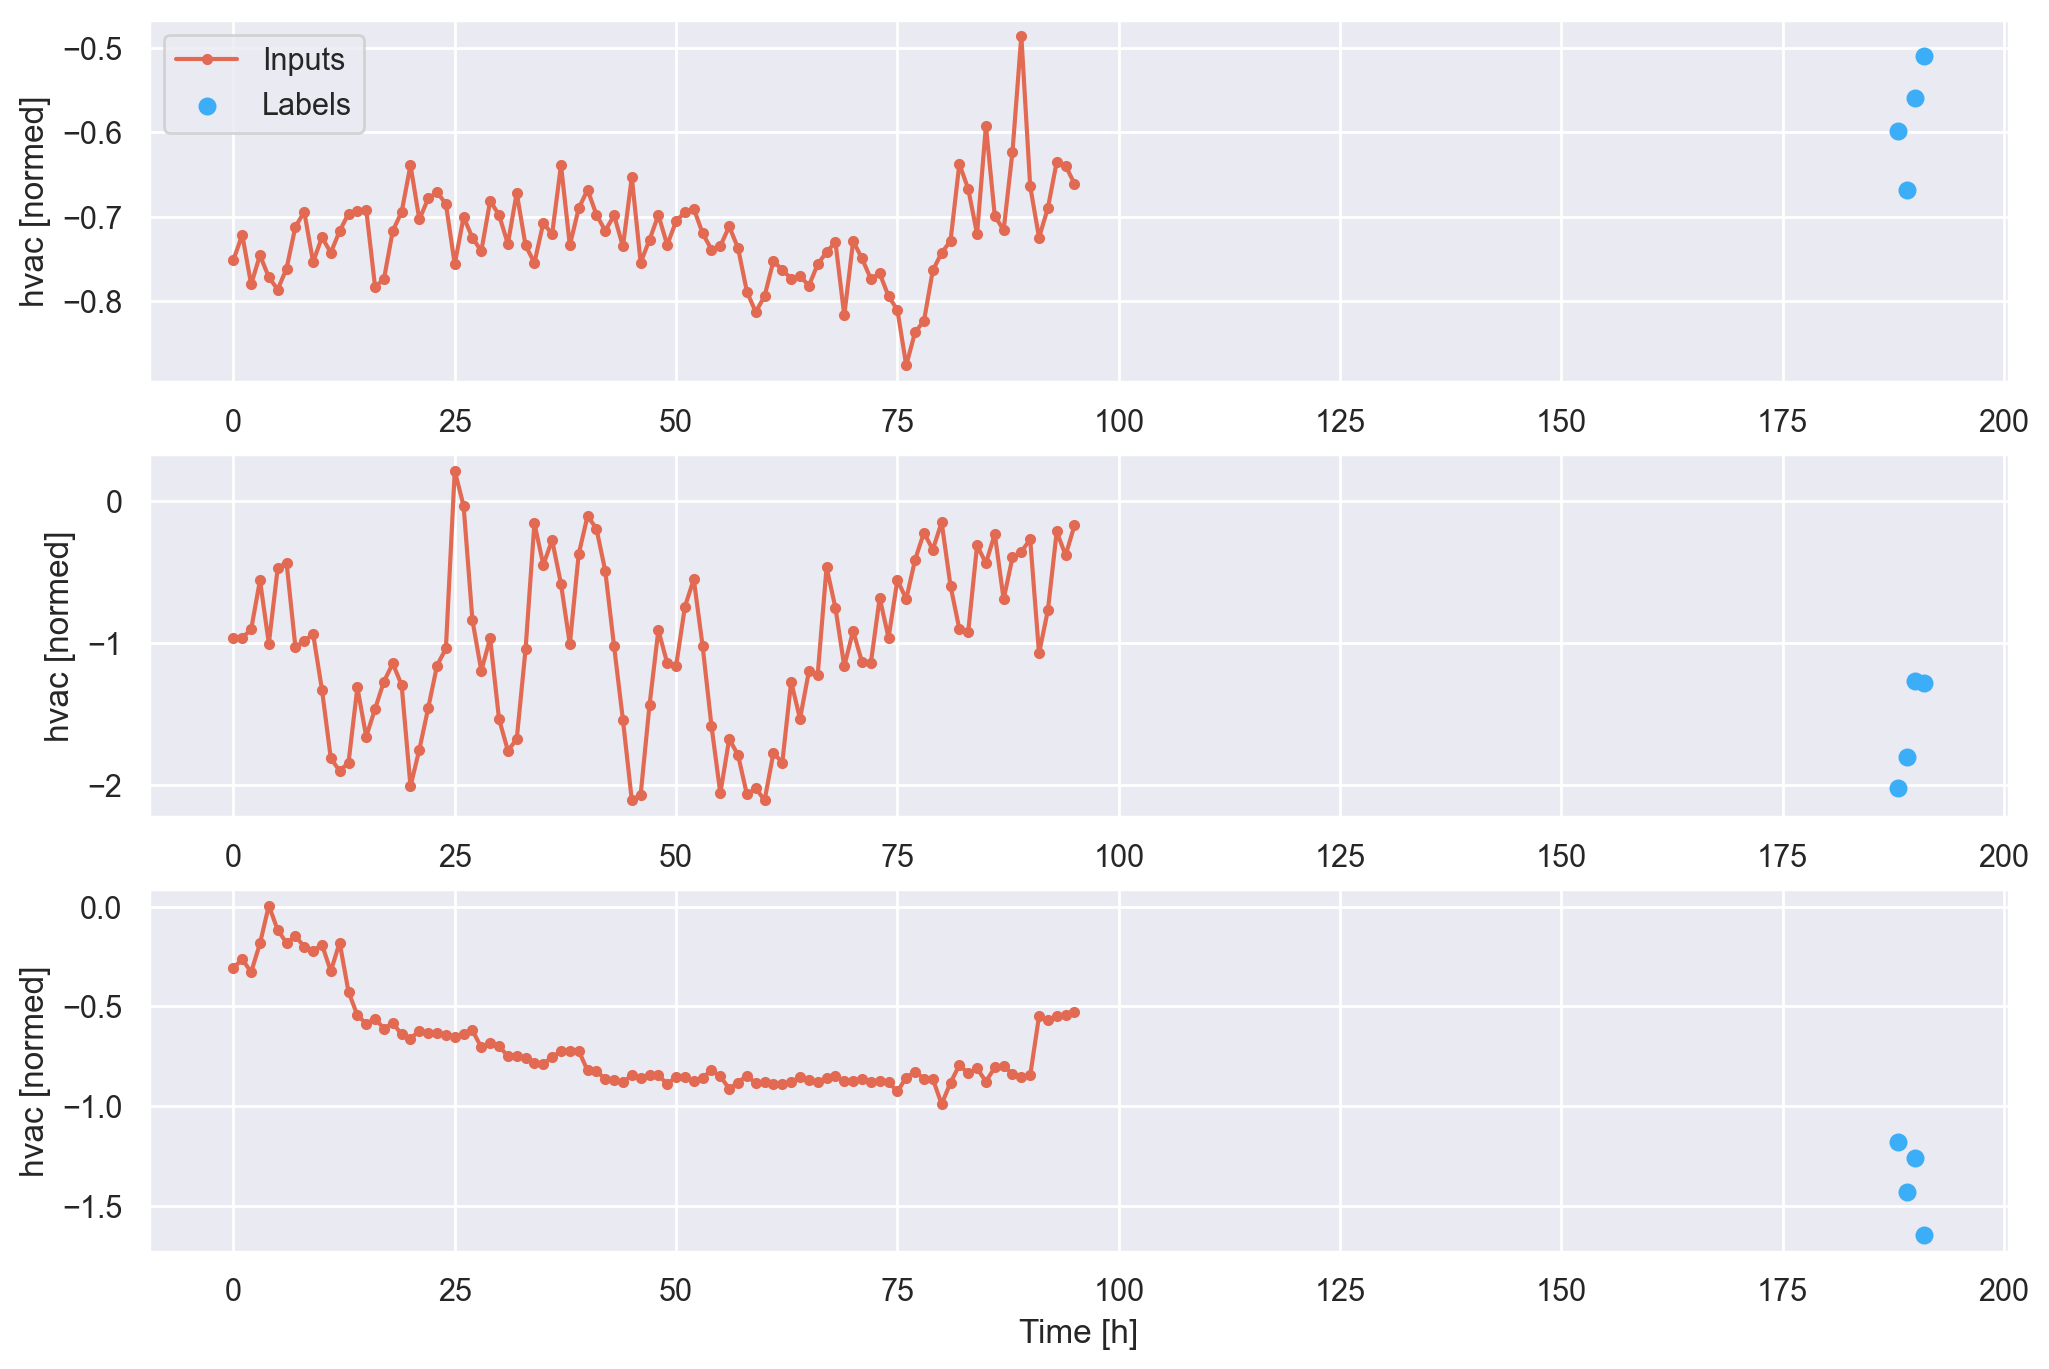

In [92]:


w1.plot1()

In [93]:
for example_inputs, example_labels in w1.train.take(1):
  print(example_inputs.shape)

(20, 96, 5)


In [94]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, optimizer='adam', lr=0.0001,epochs = 10, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
  if optimizer == 'adam':
    opt = keras.optimizers.Adam(learning_rate=lr)
  elif optimizer == 'sgd':
    opt = keras.optimizers.SGD(learning_rate=lr)
  elif optimizer == 'rmsprop':
    opt = keras.optimizers.RMSprop(learning_rate=lr)


  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=opt,
                metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanAbsolutePercentageError()])

  history = model.fit(window.train, epochs=epochs,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [96]:
val_performance ={}
performance={}

## Last-value prediction

In [97]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=[var])


In [98]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [99]:
baseline = Baseline(label_index=column_indices[var])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanAbsolutePercentageError()])


val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

759/759 [==============================] - 1s 1ms/step - loss: 0.0596 - mean_absolute_error: 0.1549 - mean_absolute_percentage_error: 108.1004


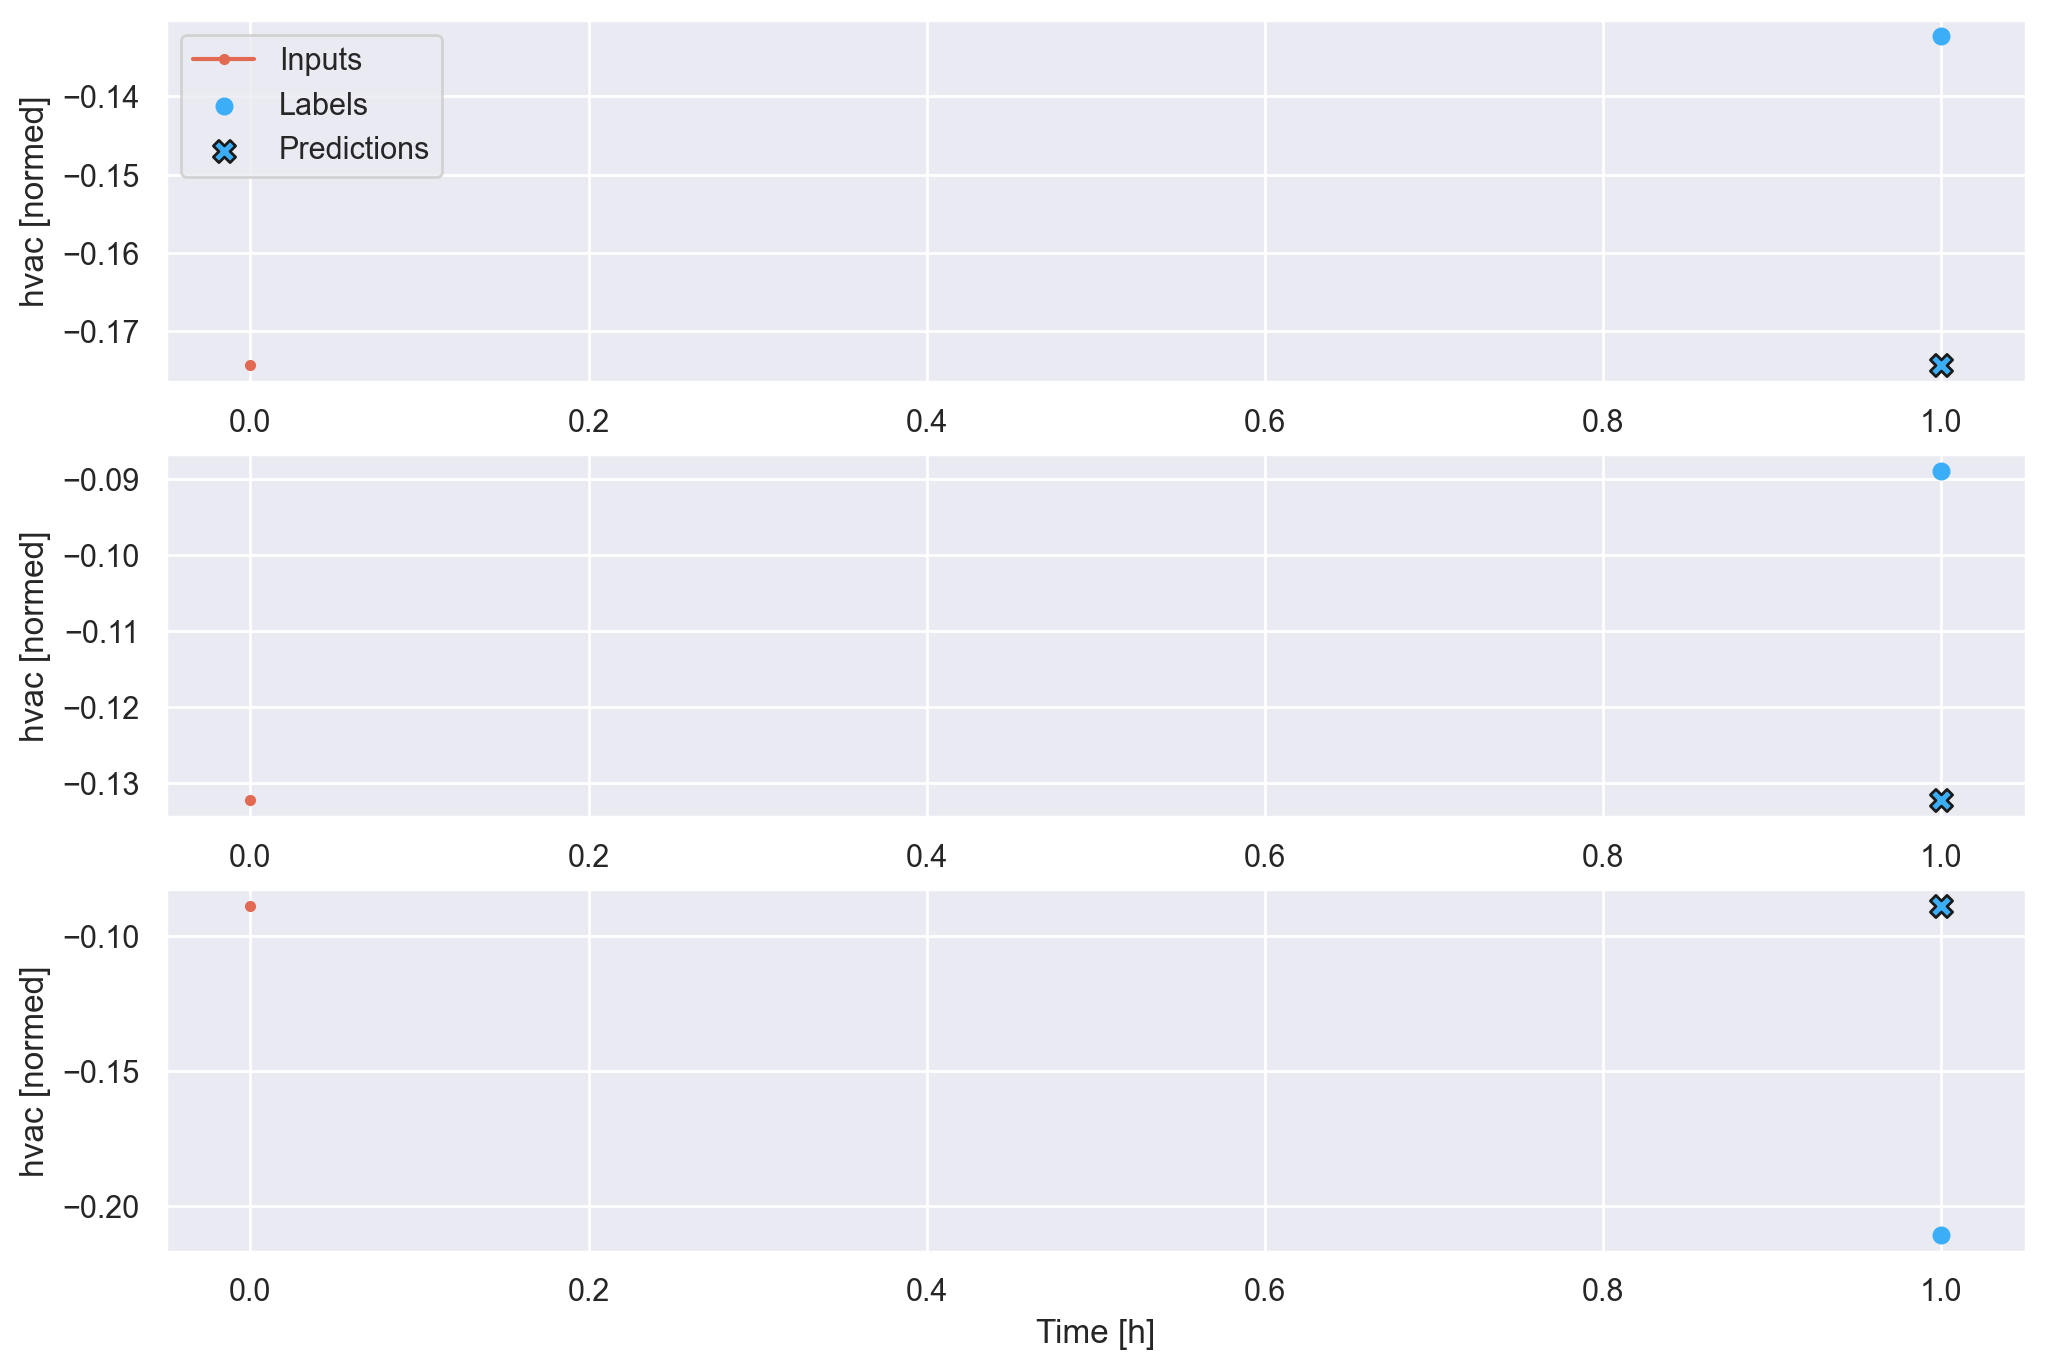

In [100]:
single_step_window.plot1(baseline)

In [101]:
single_step_window.plot_test_predictions(baseline)

All predictions shape:  (7583,)
DF test shape:  (7583, 5)


## LSTM

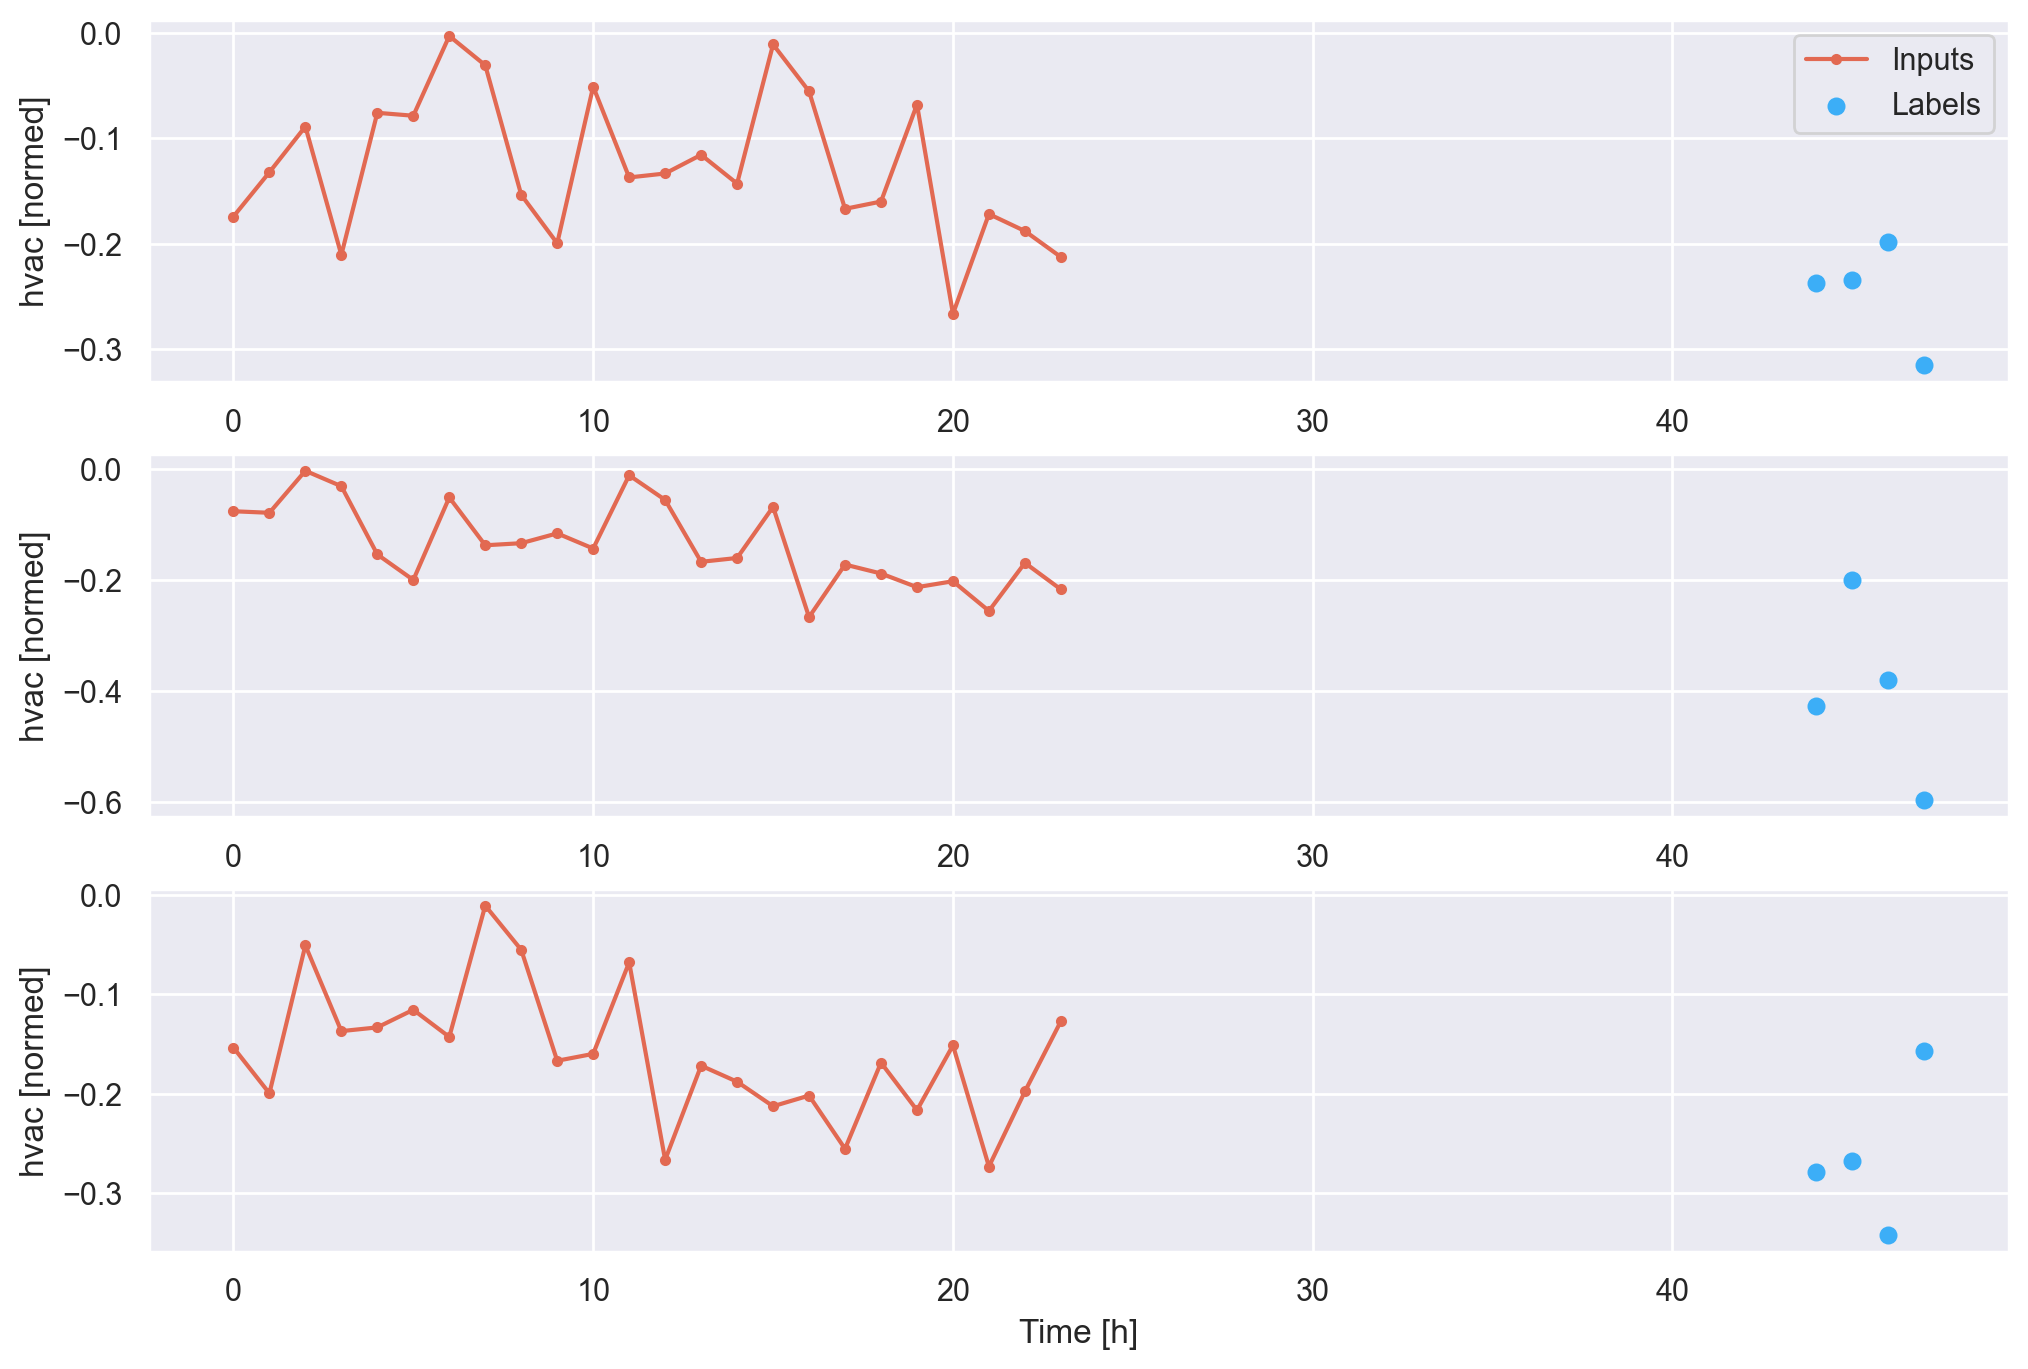

In [113]:
wide_window = WindowGenerator(
    input_width=24, label_width=4, shift=24,
    label_columns=[var])
wide_window.plot1()

In [102]:
OUT_STEPS=4
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    
    tf.keras.layers.LSTM(96, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(OUT_STEPS,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])

In [103]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)
print("Label shape", wide_window.example[1].shape)

Input shape: (20, 24, 5)
Output shape: (20, 4, 1)
Label shape (20, 4, 1)


In [104]:
history = compile_and_fit(lstm_model, wide_window)

Epoch 1/10
663/663 [==============================] - 31s 30ms/step - loss: 0.7260 - mean_absolute_error: 0.6673 - mean_absolute_percentage_error: 339.6039 - val_loss: 1.0505 - val_mean_absolute_error: 0.8524 - val_mean_absolute_percentage_error: 631.2894
Epoch 2/10
663/663 [==============================] - 17s 25ms/step - loss: 0.5420 - mean_absolute_error: 0.5577 - mean_absolute_percentage_error: 439.8731 - val_loss: 0.9046 - val_mean_absolute_error: 0.7760 - val_mean_absolute_percentage_error: 657.8888
Epoch 3/10
663/663 [==============================] - 14s 21ms/step - loss: 0.5060 - mean_absolute_error: 0.5355 - mean_absolute_percentage_error: 439.6282 - val_loss: 0.8578 - val_mean_absolute_error: 0.7485 - val_mean_absolute_percentage_error: 650.2839
Epoch 4/10
663/663 [==============================] - 13s 20ms/step - loss: 0.4924 - mean_absolute_error: 0.5266 - mean_absolute_percentage_error: 433.1559 - val_loss: 0.8351 - val_mean_absolute_error: 0.7350 - val_mean_absolute_per

In [105]:
IPython.display.clear_output()
val_performance['LSTM_1'] = lstm_model.evaluate(wide_window.val)
performance['LSTM_1'] = lstm_model.evaluate(wide_window.test, verbose=0)

189/189 [==============================] - 1s 7ms/step - loss: 0.7727 - mean_absolute_error: 0.6934 - mean_absolute_percentage_error: 652.0261


In [106]:
wide_window.plot_test_predictions(lstm_model)

All predictions shape:  (7540,)
DF test shape:  (7540, 5)


Total window size: 32
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31]
Label column name(s): None

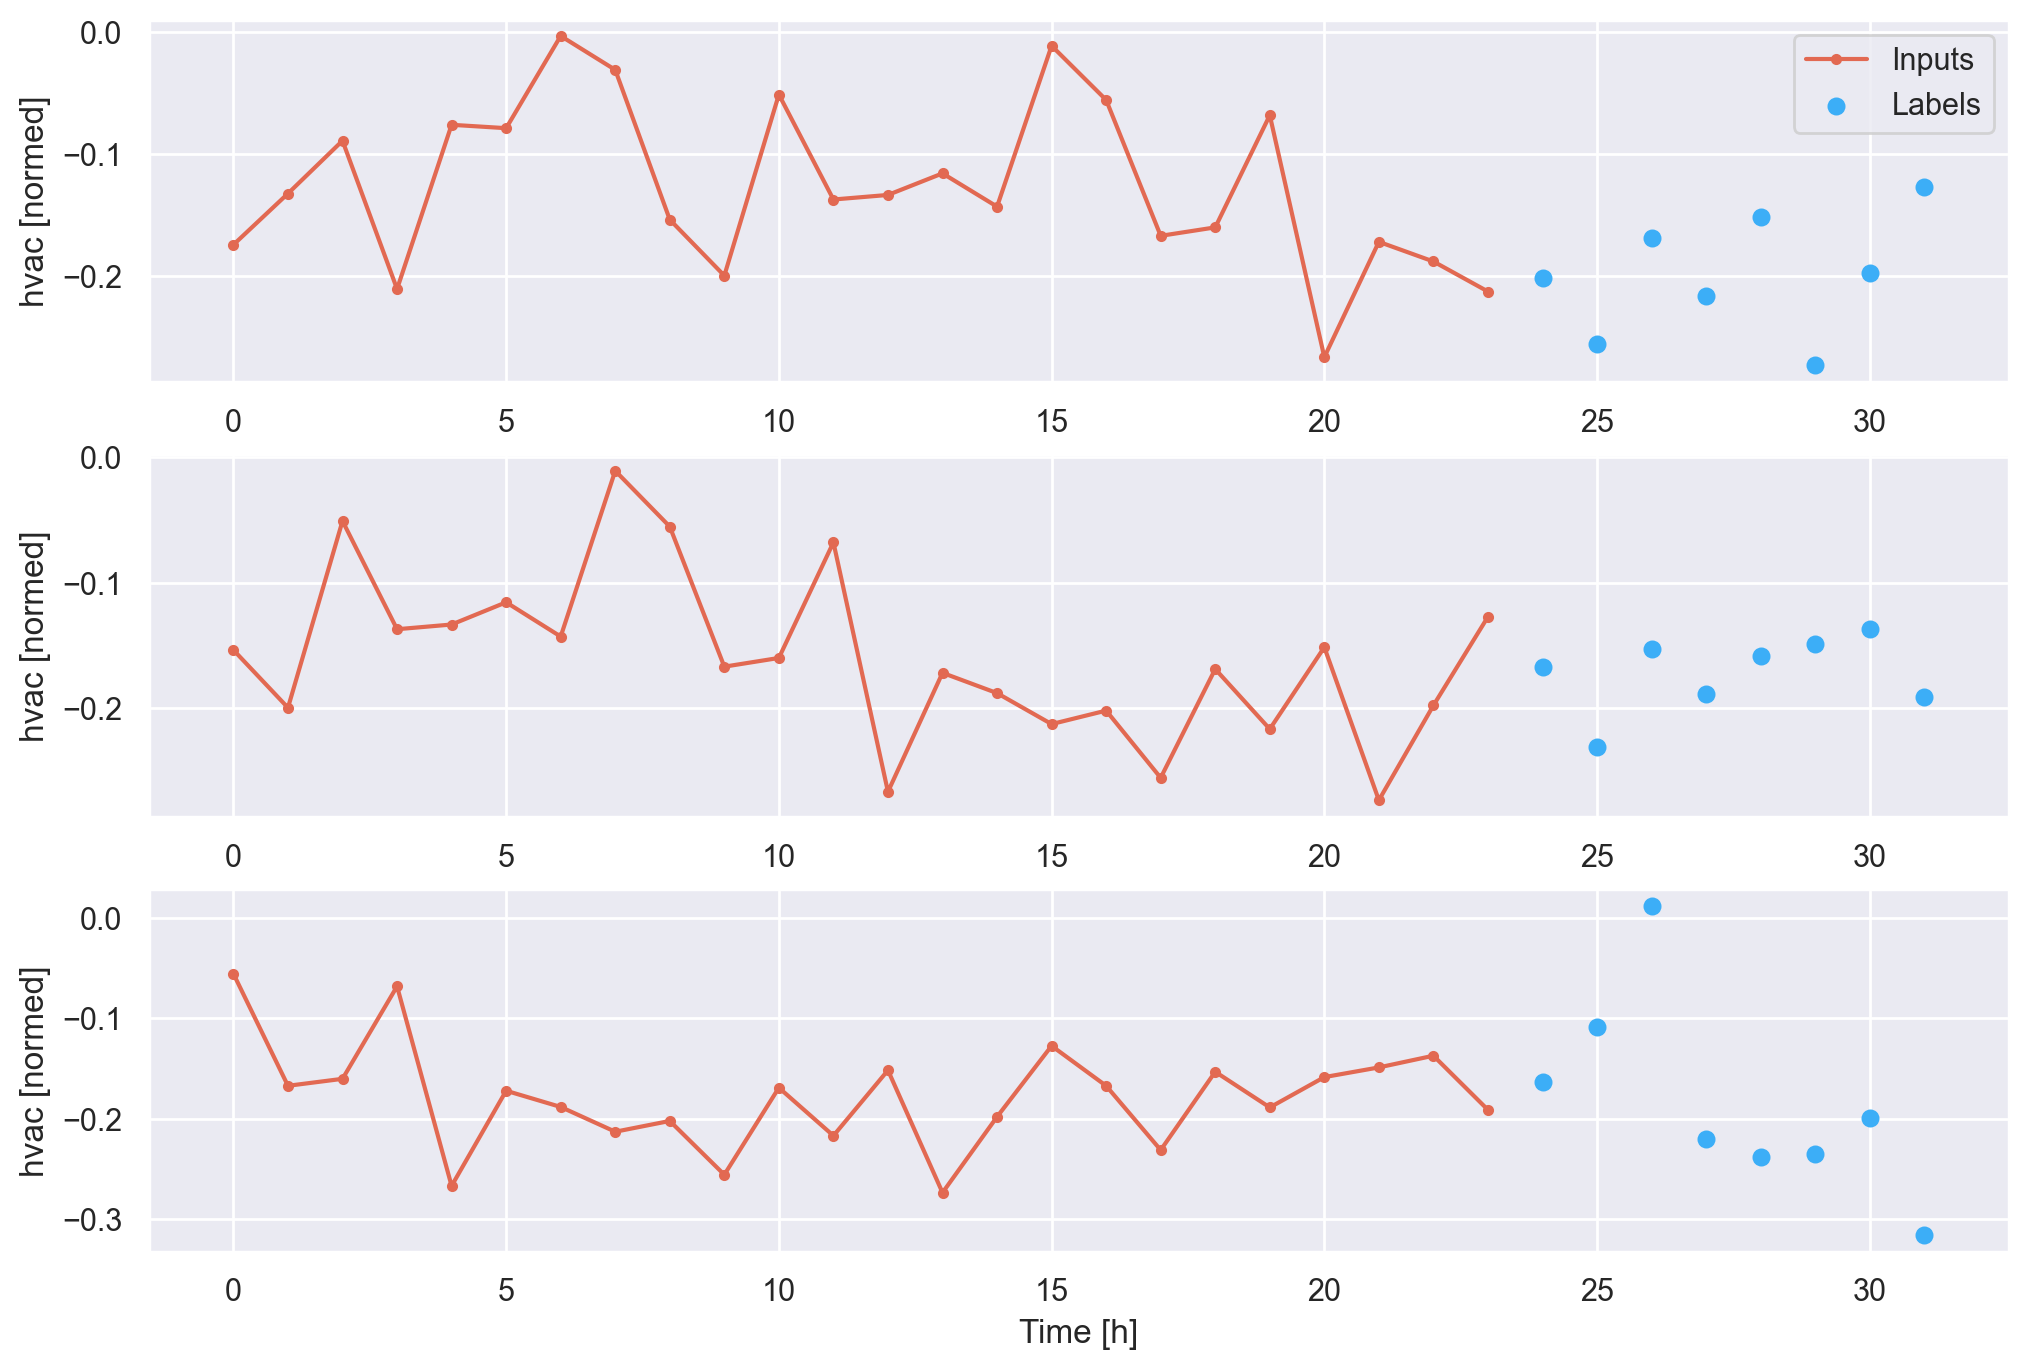

In [107]:
OUT_STEPS = 8
multi_window = WindowGenerator(input_width=24,
                               label_width=8,
                               shift=8)

multi_window.plot1()
multi_window

In [108]:
multi_window.train.element_spec

(TensorSpec(shape=(None, 24, 5), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 8, 5), dtype=tf.float32, name=None))

In [109]:
OUT_STEPS = 8
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(96, return_sequences=True, activation='tanh'),
    tf.keras.layers.LSTM(64, return_sequences=True, activation='tanh'),
    tf.keras.layers.LSTM(32, return_sequences=True, activation='relu'),
    tf.keras.layers.LSTM(16, return_sequences=False, activation='relu'),

    tf.keras.layers.Dense(OUT_STEPS,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])
print('Input shape:', multi_window.example[0].shape)
print('Output shape:', multi_lstm_model(multi_window.example[0]).shape)
print("Label shape", multi_window.example[1].shape)


history = compile_and_fit(multi_lstm_model, multi_window)




Input shape: (20, 24, 5)
Output shape: (20, 8, 1)
Label shape (20, 8, 5)
Epoch 1/10
332/332 [==============================] - 21s 27ms/step - loss: 0.8914 - mean_absolute_error: 0.8165 - mean_absolute_percentage_error: 16685.6660 - val_loss: 0.9262 - val_mean_absolute_error: 0.8237 - val_mean_absolute_percentage_error: 23897.6836
Epoch 2/10
332/332 [==============================] - 8s 25ms/step - loss: 0.8232 - mean_absolute_error: 0.7769 - mean_absolute_percentage_error: 26656.3809 - val_loss: 0.9238 - val_mean_absolute_error: 0.8226 - val_mean_absolute_percentage_error: 26367.5527
Epoch 3/10
332/332 [==============================] - 8s 24ms/step - loss: 0.8164 - mean_absolute_error: 0.7724 - mean_absolute_percentage_error: 26377.4043 - val_loss: 0.9164 - val_mean_absolute_error: 0.8172 - val_mean_absolute_percentage_error: 27184.2168
Epoch 4/10
332/332 [==============================] - 8s 23ms/step - loss: 0.8151 - mean_absolute_error: 0.7716 - mean_absolute_percentage_error: 262

In [110]:
val_performance['LSTM_2'] = multi_lstm_model.evaluate(multi_window.val)
performance['LSTM_2'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)


95/95 [==============================] - 1s 6ms/step - loss: 0.9079 - mean_absolute_error: 0.8133 - mean_absolute_percentage_error: 28900.8457


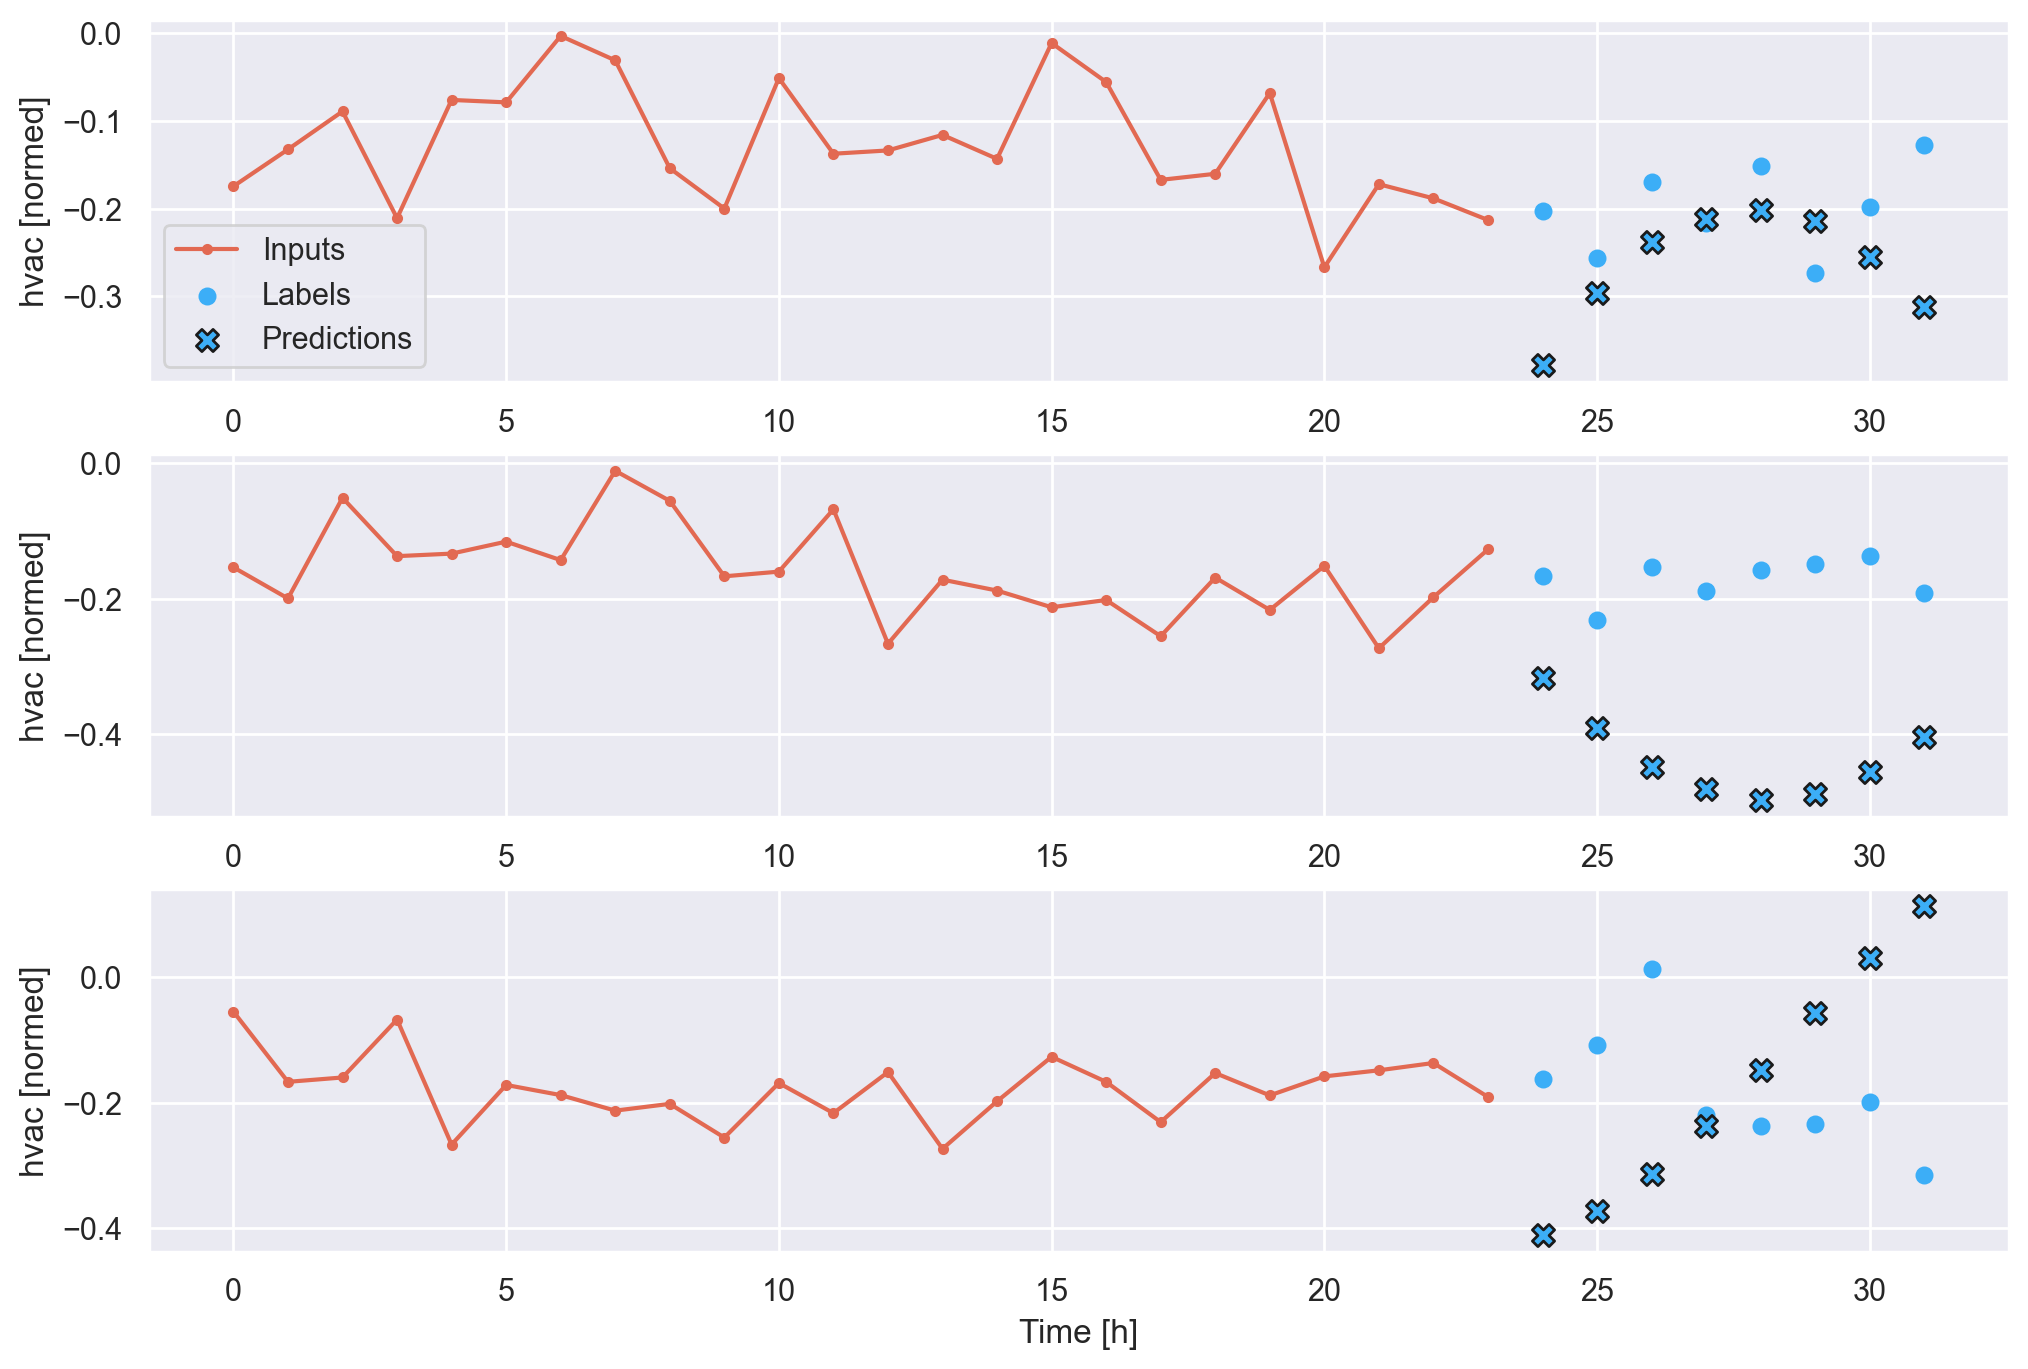

In [111]:
multi_window.plot1(multi_lstm_model)

In [112]:
multi_window.plot_test_predictions(multi_lstm_model)

All predictions shape:  (7560,)
DF test shape:  (7560, 5)


Total window size: 112
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]
Label indices: [104 105 106 107 108 109 110 111]
Label column name(s): None

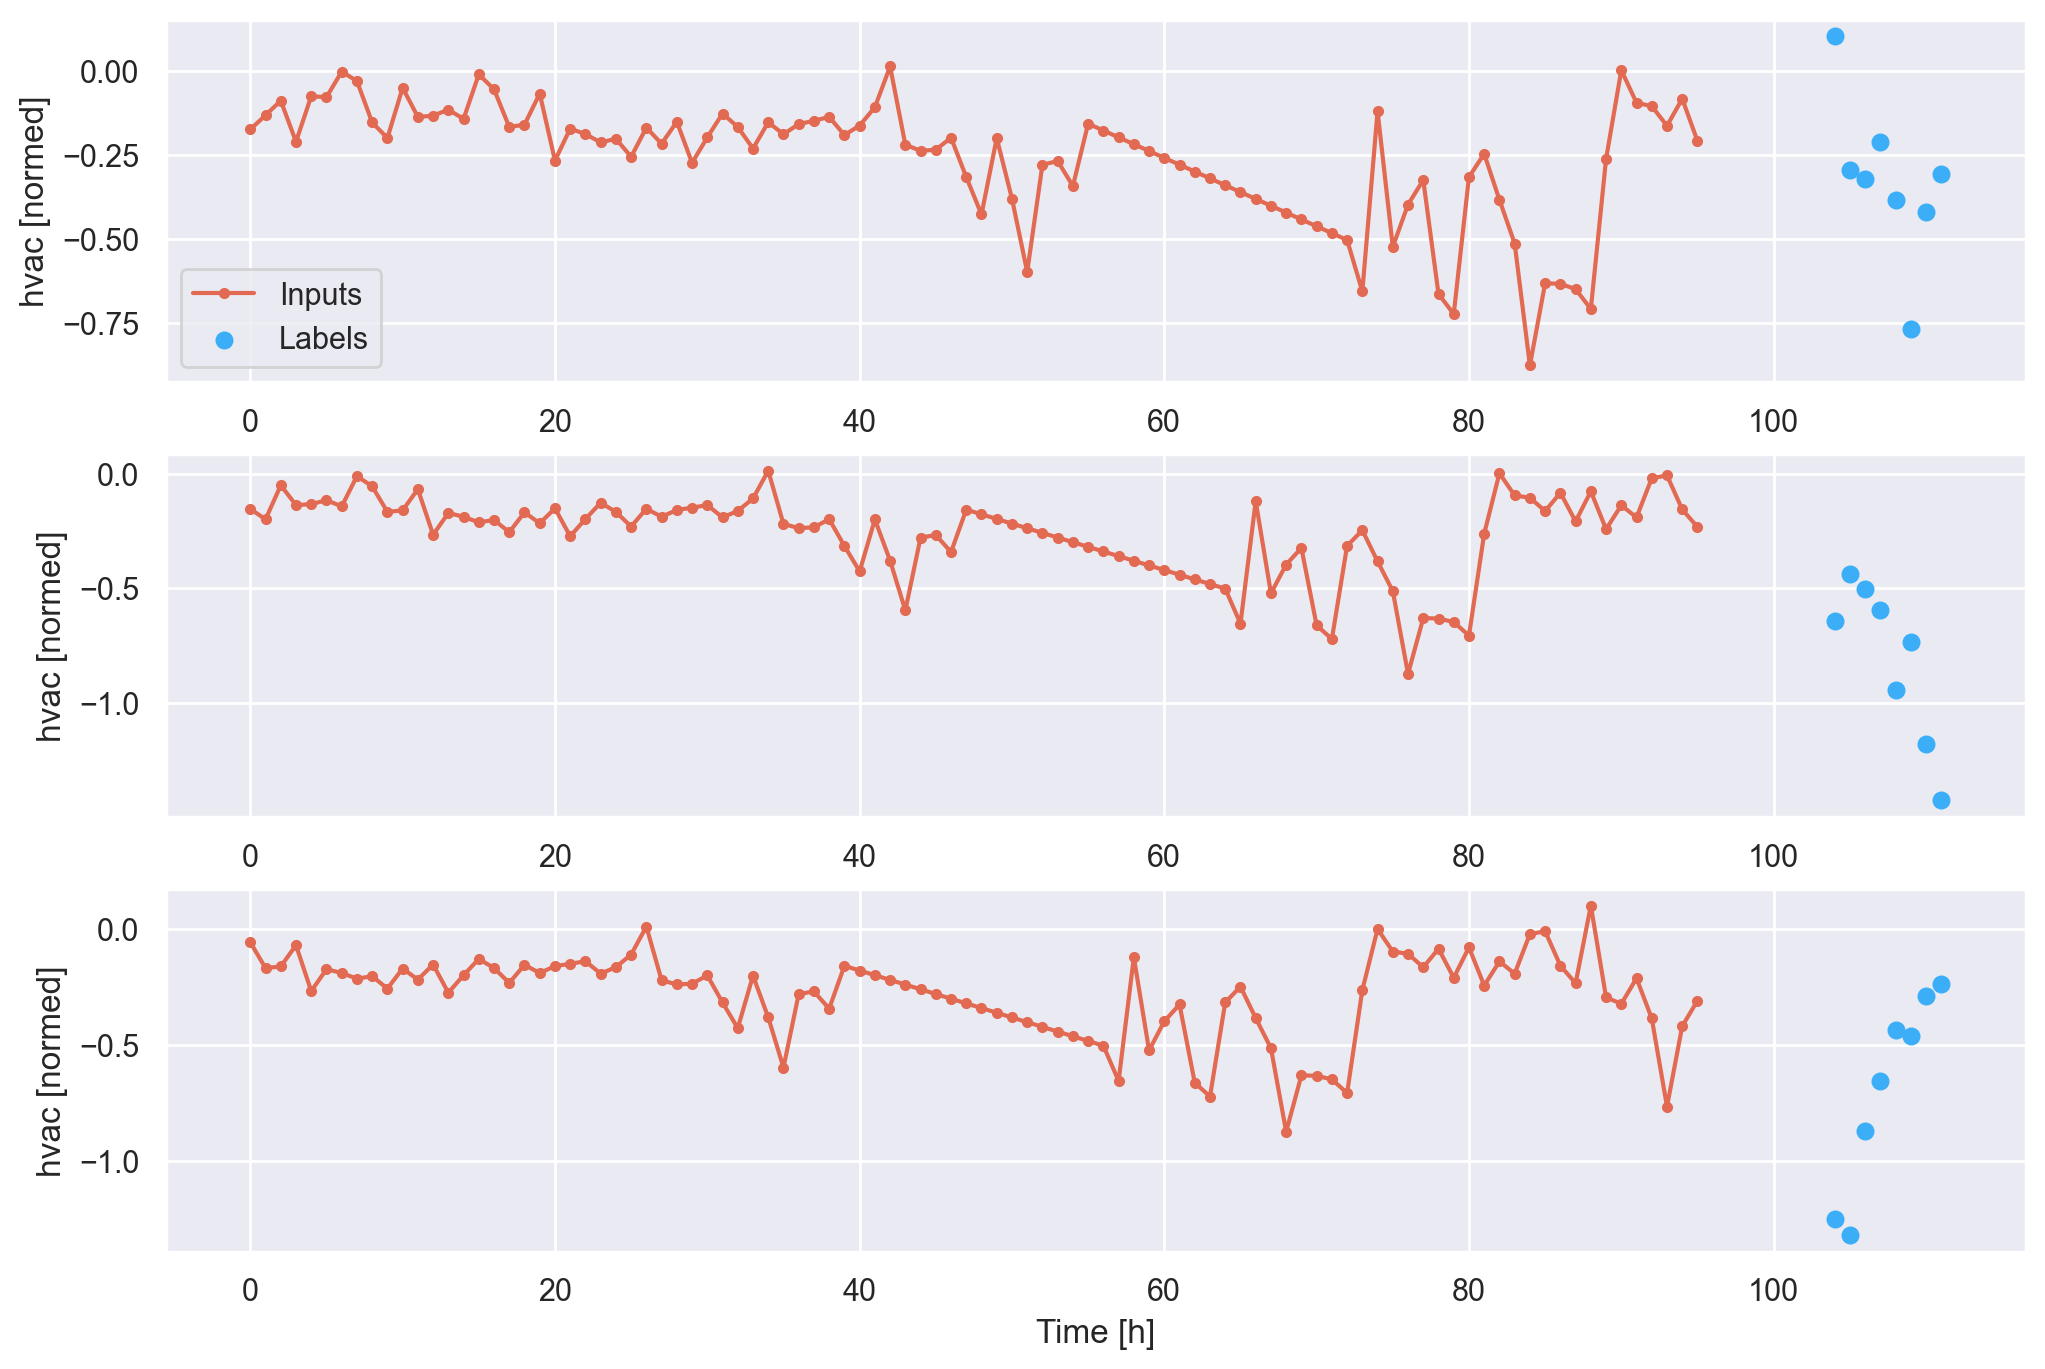

In [114]:
OUT_STEPS = 8
multi_window2 = WindowGenerator(input_width=96,
                               label_width=8,
                               shift=16)

multi_window2.plot1()
multi_window2

In [115]:
multi_window2.train.element_spec

(TensorSpec(shape=(None, 96, 5), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 8, 5), dtype=tf.float32, name=None))

In [126]:

multi_lstm_model2 = tf.keras.Sequential([
    tf.keras.layers.LSTM(96, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=False),

    tf.keras.layers.Dense(OUT_STEPS,kernel_initializer=tf.initializers.zeros()),
    
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])


print('Input shape:', multi_window2.example[0].shape)
print('Output shape:', multi_lstm_model2(multi_window2.example[0]).shape)
print("Label shape", multi_window2.example[1].shape)


history = compile_and_fit(multi_lstm_model2, multi_window2, epochs=50)




Input shape: (20, 96, 5)
Output shape: (20, 8, 1)
Label shape (20, 8, 5)
Epoch 1/50
332/332 [==============================] - 50s 128ms/step - loss: 0.9066 - mean_absolute_error: 0.8300 - mean_absolute_percentage_error: 15415.1748 - val_loss: 0.9405 - val_mean_absolute_error: 0.8319 - val_mean_absolute_percentage_error: 25594.7500
Epoch 2/50
332/332 [==============================] - 43s 129ms/step - loss: 0.8374 - mean_absolute_error: 0.7844 - mean_absolute_percentage_error: 25228.5586 - val_loss: 0.9147 - val_mean_absolute_error: 0.8158 - val_mean_absolute_percentage_error: 25582.9219
Epoch 3/50
332/332 [==============================] - 42s 127ms/step - loss: 0.8195 - mean_absolute_error: 0.7735 - mean_absolute_percentage_error: 25913.7441 - val_loss: 0.9071 - val_mean_absolute_error: 0.8092 - val_mean_absolute_percentage_error: 26804.0020
Epoch 4/50
332/332 [==============================] - 42s 127ms/step - loss: 0.8167 - mean_absolute_error: 0.7718 - mean_absolute_percentage_err

In [127]:
val_performance['LSTM_3'] = multi_lstm_model2.evaluate(multi_window2.val)
performance['LSTM_3'] = multi_lstm_model2.evaluate(multi_window2.test, verbose=0)


95/95 [==============================] - 2s 16ms/step - loss: 0.9012 - mean_absolute_error: 0.8079 - mean_absolute_percentage_error: 27497.8125


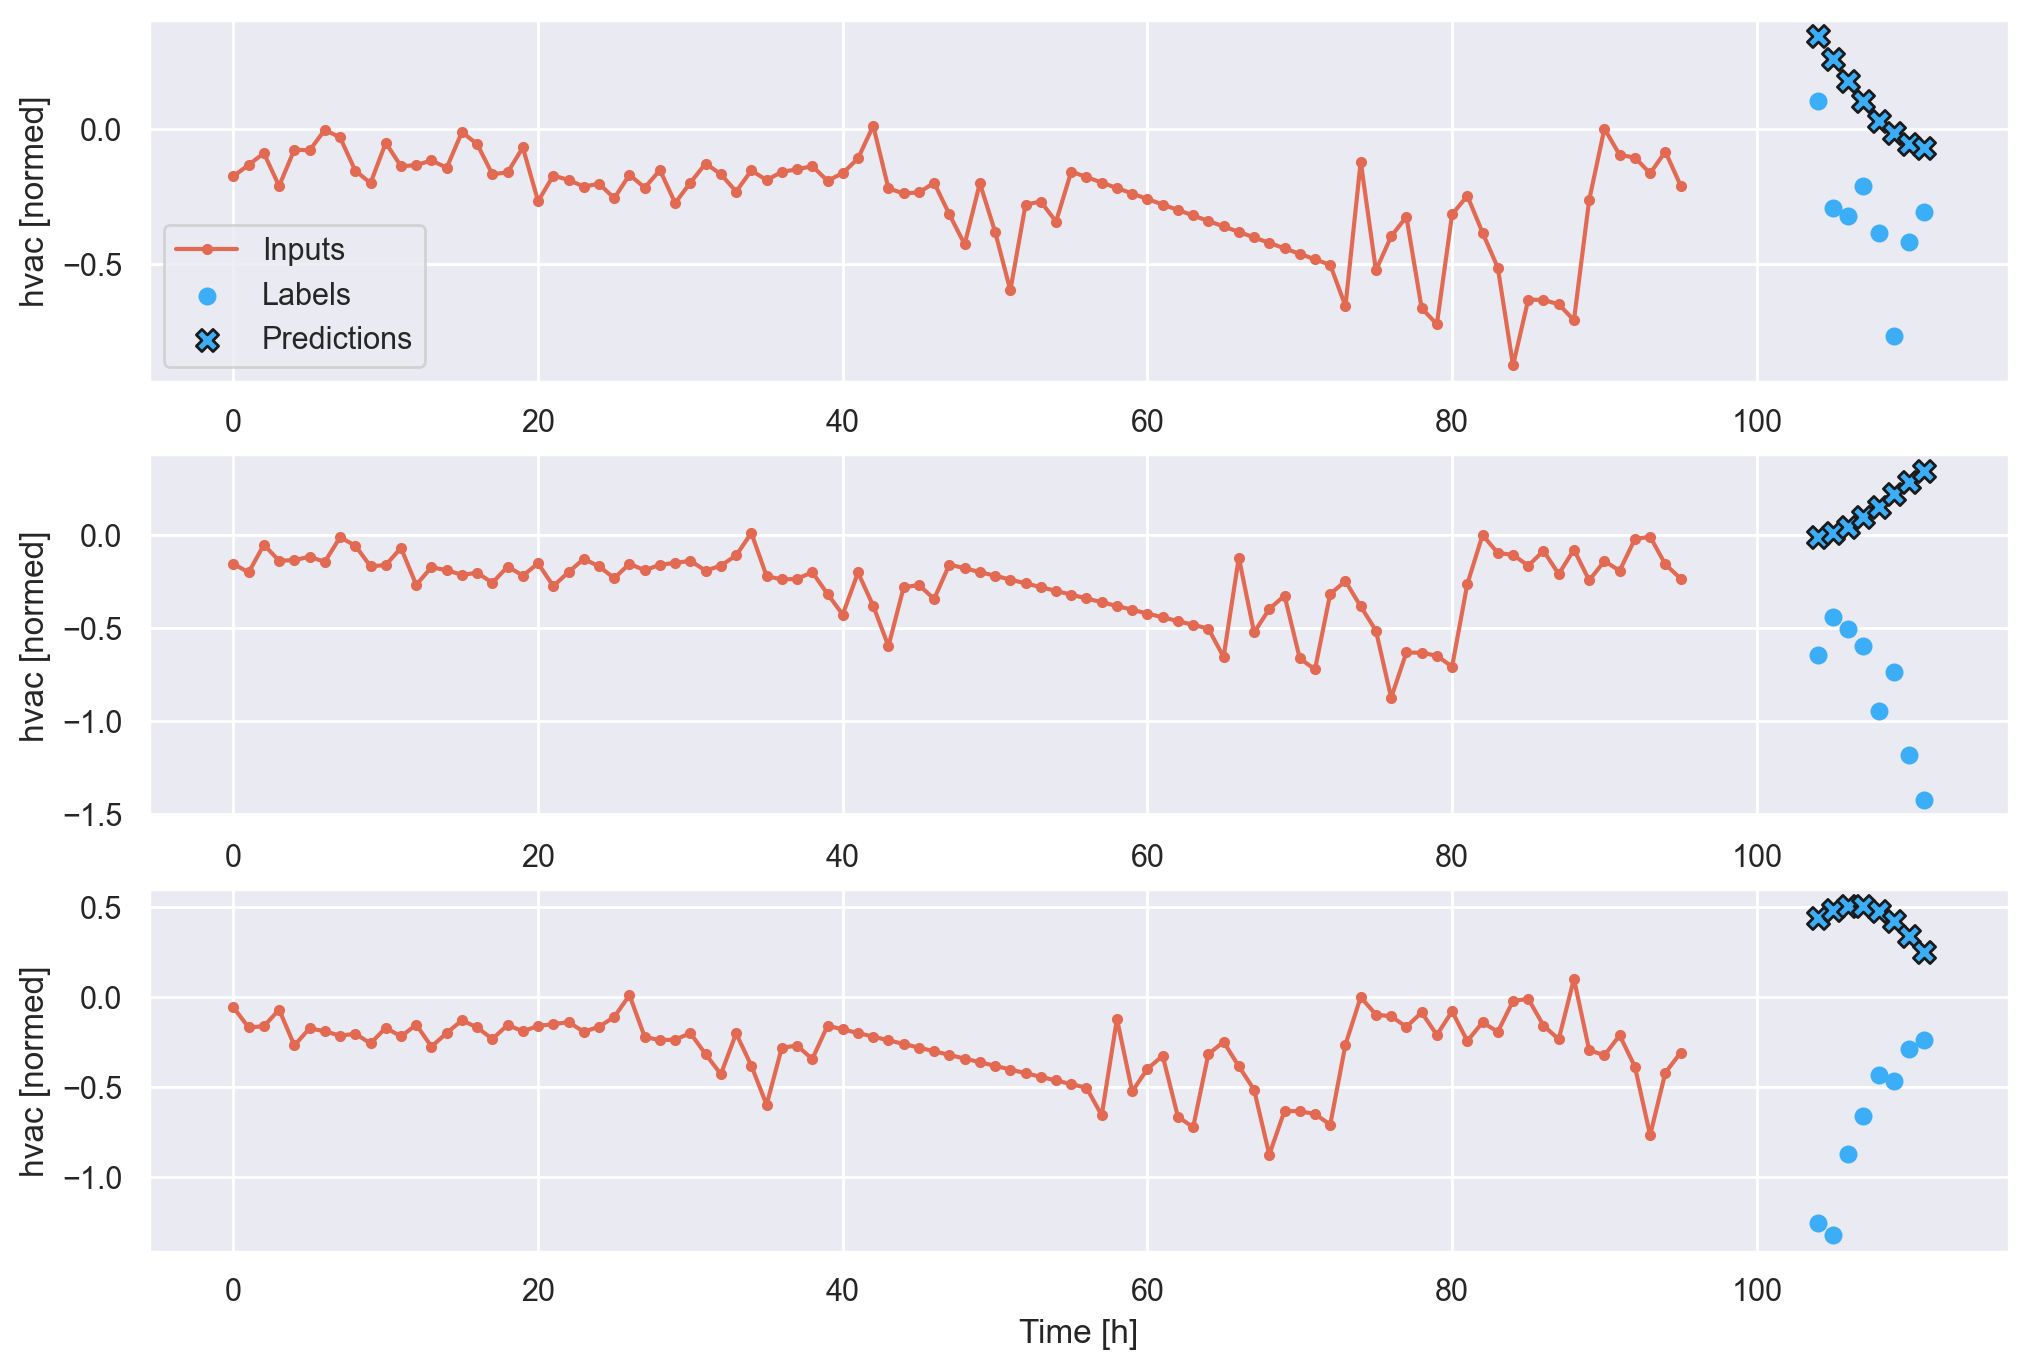

In [129]:
multi_window2.plot1(multi_lstm_model2)

In [130]:
multi_window2.plot_test_predictions(multi_lstm_model2)

All predictions shape:  (7480,)
DF test shape:  (7480, 5)


## WANDB

2023-03-17 16:14:16.637559: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Total window size: 32
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31]
Label column name(s): None

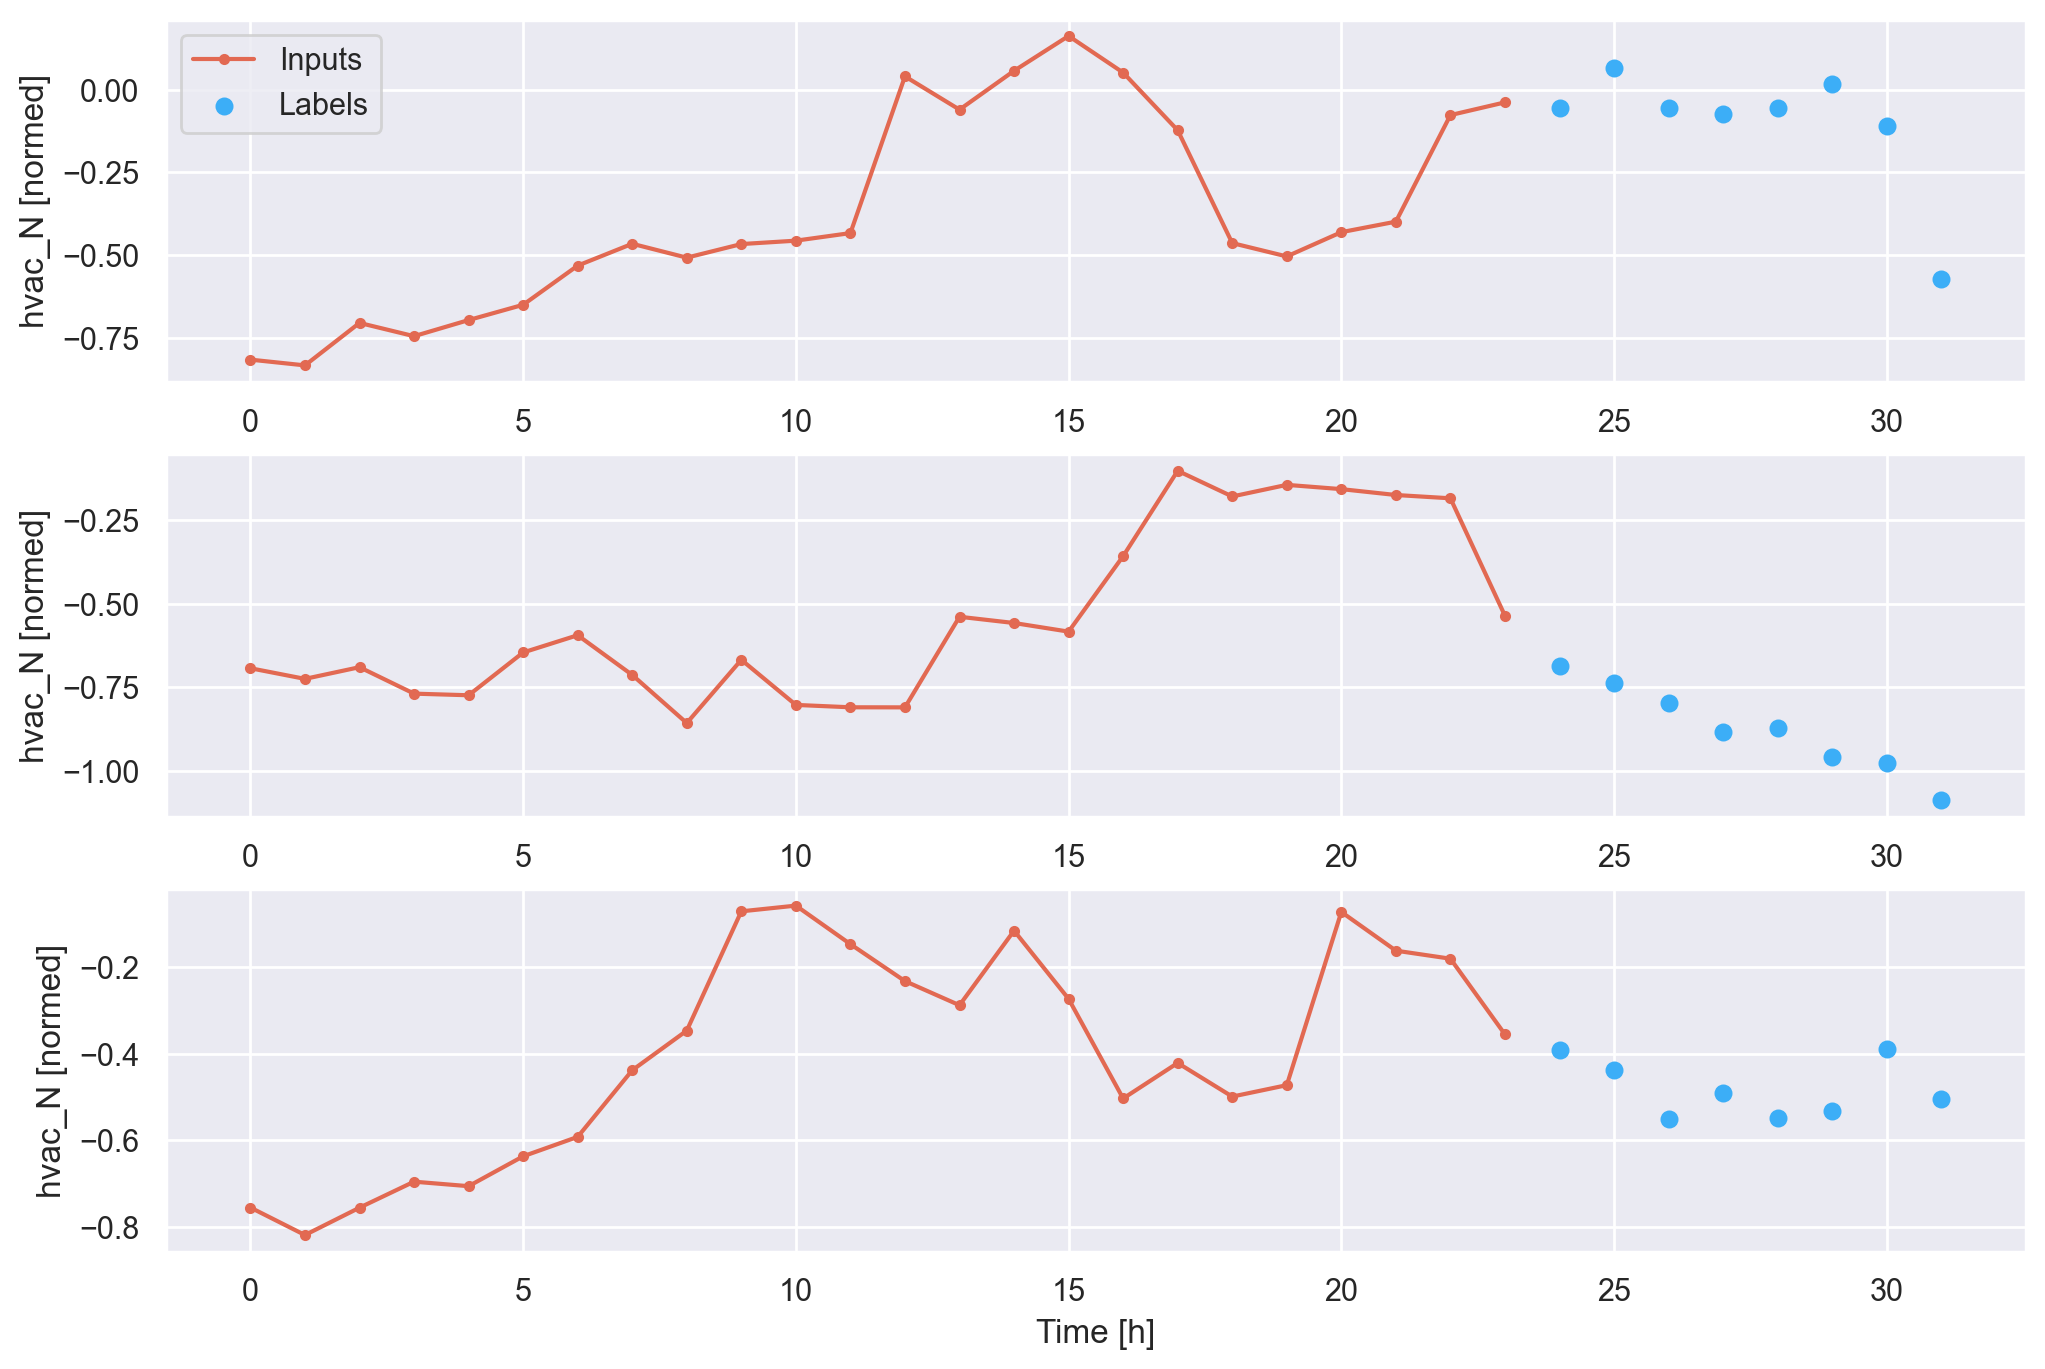

In [22]:
OUT_STEPS = 8
multi_window = WindowGenerator(input_width=24,
                               label_width=8,
                               shift=8)

multi_window.plot1()
multi_window

In [41]:

import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

import random
import numpy as np
import tensorflow as tf
from tensorflow import keras


In [33]:



# Start a run, tracking hyperparameters
wandb.init(
    # set the wandb project where this run will be logged
    project="tfg-maria",

    # track hyperparameters and run metadata with wandb.config
    config={
        "layer_1": 192,
        "activation_1": "softmax",
        "dropout_1": random.uniform(0.01, 0.80),
        "dropout_2": random.uniform(0.01, 0.80),

        "layer_2": 96,
        "activation_2": "softmax",
        "layer_3": 32,
        "activation_3": "softmax",
        "layer_4": 8,
        "activation_4": "softmax",

        "optimizer": "Adam",
        "loss": "mean_squared_error",
        "metric": "mean_absolute_error",
        "epoch": 8,
        "batch_size": 20
    }
)

# [optional] use wandb.config as your config
config = wandb.config


model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(config.layer_1, activation=config.activation_1, return_sequences=True),
    tf.keras.layers.Dropout(config.dropout_1),
    tf.keras.layers.LSTM(config.layer_2, activation=config.activation_2, return_sequences=True),
    tf.keras.layers.Dropout(config.dropout_2),
    tf.keras.layers.LSTM(config.layer_3 ,activation=config.activation_3, return_sequences=False),
    tf.keras.layers.Dense(config.layer_4, activation=config.activation_4),
    
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])




# compile the model
model.compile(optimizer=config.optimizer,
              loss=config.loss,
              metrics=[config.metric]
              )





# WandbMetricsLogger will log train and validation metrics to wandb
# WandbModelCheckpoint will upload model checkpoints to wandb
history = model.fit(multi_window.train,
                    epochs=config.epoch,
                    batch_size=config.batch_size,
                    validation_data=multi_window.test,
                    callbacks=[
                      WandbMetricsLogger(log_freq=5),
                      WandbModelCheckpoint("models")
                    ])

# [optional] finish the wandb run, necessary in notebooks
wandb.finish()

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/8


2023-03-16 18:56:03.198010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 28/332 [=>............................] - ETA: 9:17 - loss: 1.0128 - mean_absolute_error: 0.8841

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


 32/332 [=>............................] - ETA: 9:10 - loss: 1.0070 - mean_absolute_error: 0.8825

wandb: ERROR Error while calling W&B API: run tfg-maria/tfg-maria/cb6b8i6i was previously created and deleted; try a new run name (<Response [409]>)
wandb: ERROR Error while calling W&B API: run tfg-maria/tfg-maria/cb6b8i6i was previously created and deleted; try a new run name (<Response [409]>)


 34/332 [==>...........................] - ETA: 9:06 - loss: 1.0048 - mean_absolute_error: 0.8815

wandb: ERROR Error while calling W&B API: run tfg-maria/tfg-maria/cb6b8i6i was previously created and deleted; try a new run name (<Response [409]>)


 37/332 [==>...........................] - ETA: 8:58 - loss: 1.0026 - mean_absolute_error: 0.8815

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Error while calling W&B API: run tfg-maria/tfg-maria/cb6b8i6i was previously created and deleted; try a new run name (<Response [409]>)


 42/332 [==>...........................] - ETA: 8:49 - loss: 1.0037 - mean_absolute_error: 0.8821

wandb: ERROR Error while calling W&B API: run tfg-maria/tfg-maria/cb6b8i6i was previously created and deleted; try a new run name (<Response [409]>)


KeyboardInterrupt: 

### WANDB with sweeps

In [35]:
# Select the hyperparameters you want to tune. This is specified like the following:
sweep_config = {
   'method': 'random',
   'name': 'sweep',
   'metric': {
        'goal': 'minimize', 
        'name': 'validation_loss'
        },

   'parameters': {
       'hidden_layer_size': {'values': [32, 64, 96, 128, 256]},
       'activation_hl':{'values': ['relu', 'softmax']},
       'batch_size': {'values': [16, 32, 64]},
        'epochs': {'values': [10, 50, 80]},
        'lr': {'max': 0.1, 'min': 0.0001},
        'dropout':{'max':0.9, 'min':0.0},
        "optimizer": {
            "values": ['adam', 'sgd', 'rmsprop']
        }
   }
}

sweep_id = wandb.sweep(sweep=sweep_config, project="tfg-maria")

Create sweep with ID: cj7og6sn
Sweep URL: https://wandb.ai/tfg-maria/tfg-maria/sweeps/cj7og6sn


In [24]:
sweep_id='lmzzvpxi'

In [25]:
def train_sweep():

# Specify the hyperparameter to be tuned along with
   # an initial value
  default_configs = {
    'hidden_layer_size': 128,
    'activation_hl':'relu',
    'batch_size':16,
    'epochs': 10,
    'lr': 0.0001,
    'dropout':0.2,


    "layer_1": 192,
    "activation_1": "softmax",
    "dropout_1": random.uniform(0.01, 0.80),
    "dropout_2": random.uniform(0.01, 0.80),

    "layer_2": 96,
    "activation_2": "softmax",
    "layer_3": 32,
    "activation_3": "softmax",
    "layer_4": 8,
    "activation_4": "softmax",

    "optimizer": "adam",
    "loss": "mean_squared_error",
    "metric": "mean_absolute_error",
  }

  wandb.init(config=default_configs, resume=True)
  
  config = wandb.config
  hidden_layer_size = config.hidden_layer_size
  activation_hl = config.activation_hl
  batch_size = config.batch_size
  epochs = config.epochs
  lr = config.lr
  dropout = config.dropout
  optimizer = config.optimizer

  if config.optimizer == 'adam':
    optimizer = keras.optimizers.Adam(learning_rate=lr)
  elif config.optimizer == 'sgd':
    optimizer = keras.optimizers.SGD(learning_rate=lr)
  elif config.optimizer == 'rmsprop':
    optimizer = keras.optimizers.RMSprop(learning_rate=lr)


  model = tf.keras.Sequential([
  # Shape [batch, time, features] => [batch, lstm_units].
  # Adding more `lstm_units` just overfits more quickly.
  tf.keras.layers.LSTM(config.layer_1, activation=config.activation_1, return_sequences=True),
  tf.keras.layers.Dropout(config.dropout_1),
  tf.keras.layers.LSTM(hidden_layer_size, activation_hl, return_sequences=False),
  tf.keras.layers.Dropout(dropout),
  tf.keras.layers.Dense(config.layer_4, activation=config.activation_4),

  # Shape => [batch, out_steps, features].
  tf.keras.layers.Reshape([OUT_STEPS, 1])
  ])


  model.compile(
        optimizer=optimizer,
        loss=config.loss,
        metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error']
    )

  # Train the model
  model.fit(multi_window.train,
                  epochs=epochs,
                  batch_size=batch_size,
                  validation_data=multi_window.val,
                  callbacks=[
                    WandbMetricsLogger(log_freq='epoch')
                  ])


  #model.save('Models/LSTM_prueba.h5', overwrite=True)
   

In [28]:
wandb.agent(sweep_id=sweep_id, function=train_sweep, project='tfg-maria')

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.
wandb: Ctrl + C detected. Stopping sweep.


#### Trying one of the best wandb models

In [64]:
config = {
    'hidden_layer_size': 128,
    'activation_hl':'tanh',
    'batch_size':16,
    'epochs': 10,
    'lr': 0.003369,
    'dropout':0.45,
    'layer_1': 192,
    'activation_1': "tanh",
    'dropout_1': 0.3,
    'dropout_2': random.uniform(0.01, 0.80),
    'layer_2': 96,
    'activation_2': "softmax",
    'layer_3': 32,
    'activation_3': "softmax",
    'layer_4': 8,
    'activation_4': "tanh",
    'optimizer': "adam",
    'loss': "mean_squared_error",
    'metric': "mean_absolute_error",
  }



In [65]:
model = tf.keras.Sequential([
  # Shape [batch, time, features] => [batch, lstm_units].
  # Adding more `lstm_units` just overfits more quickly.
  tf.keras.layers.LSTM(config['layer_1'], activation=config['activation_1'], return_sequences=True),
  tf.keras.layers.Dropout(config['dropout_1']),
  tf.keras.layers.LSTM(config['hidden_layer_size'], config['activation_hl'], return_sequences=False),
  tf.keras.layers.Dropout(config['dropout']),
  tf.keras.layers.Dense(config['layer_4'], activation=config['activation_4']),

  # Shape => [batch, out_steps, features].
  tf.keras.layers.Reshape([OUT_STEPS, 1])
  ])

In [66]:
print('Input shape:', multi_window.example[0].shape)
print('Output shape:', model(multi_window.example[0]).shape)
print("Label shape", multi_window.example[1].shape)
history = compile_and_fit(model,  multi_window,lr = config['lr'], epochs=config['epochs'])


IPython.display.clear_output()


In [67]:
val_performance['LSTM_wb'] = model.evaluate(multi_window.val)
performance['LSTM_wb'] = model.evaluate(multi_window.test, verbose=0)
multi_window.plot_test_predictions(model)



95/95 [==============================] - 1s 8ms/step - loss: 0.8680 - mean_absolute_error: 0.7917
All predictions shape:  (7560,)
DF test shape:  (7560, 5)
